# Model training: predict the demand before and after the first 2 weeks of markdown

## Summary
- The model captures the purchase difference well (explains ~79% of the variance) among 3 weeks even though some underestimation at very high volumes

In [0]:
%pip install scikit-learn==1.3.2 xgboost==2.0.3 numpy==1.23.5 scipy==1.11.1 imbalanced-learn==0.12.4 --force-reinstall

  Obtaining dependency information for scikit-learn==1.3.2 from https://files.pythonhosted.org/packages/0c/2a/d3ff6091406bc2207e0adb832ebd15e40ac685811c7e2e3b432bfd969b71/scikit_learn-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached scikit_learn-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Obtaining dependency information for xgboost==2.0.3 from https://files.pythonhosted.org/packages/c3/eb/496aa2f5d356af4185f770bc76055307f8d1870e11016b10fd779b21769c/xgboost-2.0.3-py3-none-manylinux2014_x86_64.whl.metadata
  Using cached xgboost-2.0.3-py3-none-manylinux2014_x86_64.whl.metadata (2.0 kB)
  Obtaining dependency information for numpy==1.23.5 from https://files.pythonhosted.org/packages/e8/ad/b935c7421657a032fd2a5332eed098f3b9993a155afceb1daa280ff6611f/numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64

In [0]:
dbutils.library.restartPython()

In [0]:
# Foundamental libraries 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Import self-created classes
from pathlib import Path
import sys
sys.path.append(str(Path().resolve().parent.parent) + "/weekend/src")
from data_prep import DataPrep, DailyTransfomer, FullDateTransformer
from feature_engineering import FeatureGenerator

# Model training libraries
import xgboost as xgb
xgb.set_config(verbosity=0)  # Suppress warnings
from xgboost import XGBRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Model evaluation and feature importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [0]:
path_to_prod = '../data/product_table.csv'
path_to_sales = '../data/sales_master.csv'
data_prep = DataPrep(path_to_prod, path_to_sales)
df_start = data_prep.data_merger()
print(f"There are {df_start.shape[0]} rows in the combined table.")
df_start.head(5)

There are 46072 rows in the combined table.


/Workspace/Users/ming.zhan@if.se/SelfTraining/casestudy/weekend/src/data_prep.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sales['variant_parent'] = df_sales['variant'].map(lambda x: x//1000)


,date,variant,purchases,net_amount,gross_amount,variant_parent,PRODUCT_CODE,PRODUCT_TYPE_NAME,DEPARTMENT_ID,DEPARTMENT_NAME,INDEX_GROUP_NAME,SECTION_NAME,article,week
0,2017-10-02,494340001004,1.0,19.282061,19.99,494340001,494340,Jumper/Sweater,176,Basics,Menswear,Men Underwear,494340001,week0
1119,2017-10-02,443102004044,4.0,194.159203,199.96,443102004,443102,Outdoor jacket,53,Outdoor/Blazers,Divided,Divided Collection DOTS,443102004,week0
1118,2017-10-02,305679001404,10.0,90.677071,99.90,305679001,305679,Cushion cover,501,Fancy cushion covers,Home,Live,305679001,week0
1117,2017-10-02,474138005038,3.0,69.099462,74.97,474138005,474138,Swimsuit,159,Swimwear,Ladieswear,"Women Swimwear, Functional & M",474138005,week0
1116,2017-10-02,474138005036,2.0,46.551399,49.98,474138005,474138,Swimsuit,159,Swimwear,Ladieswear,"Women Swimwear, Functional & M",474138005,week0


### Data Aggragation

In [0]:
daily_transfomer = DailyTransfomer(df_start)
group_cols = ['week',"date", "article"]
df_daily = daily_transfomer.transform(group_cols)
df_daily.sample(5)

,week,date,article,purchases,price,discount
1601,week0,2017-10-04,519145001,7.0,17.99,0.07
11061,week2,2017-10-19,510314005,3.0,14.99,0.17
11489,week2,2017-10-20,461439001,2.0,12.99,0.45
1755,week0,2017-10-05,258393002,26.0,5.99,0.02
2560,week0,2017-10-06,476376001,1.0,7.99,0.09


In [0]:
full_date = FullDateTransformer(df_daily)
df_daily_full = full_date.full_date_transformer()
df_daily_full.sample(2)

,article,week,date,purchases,price,discount
12827,505468003,week2,2017-10-19,11.0,17.99,0.47
13935,544565002,week2,2017-10-21,0.0,NaN,0.00


### Feature engineering

In [0]:
# Features:
# sold_days: how many days in that week the product has purchase greater than 0, range from 0 to 7
# markdown: whether it is a markdown week, 1 means yes, 0 means no
# price: gross_amout / purchases
# discount: 1 - net_amount / gross_amount
# base_line_purchases: average daily purchases in the week before markdown for each product
# price_ratio: price / base_line_price
# is_first_md_day: whether it is the first day of markdown week, 1 means yes, 0 means no
# discount_rank: 1:(0-0.2], 2 : (0.2-0.3], 3 : (0.3-0.51], 4 : (0.51, 1]
# week: which week is the purchase belong to
# purchases_lag1: yesterday’s purchases for the same product to capture the short-term memontum
feature_generation = FeatureGenerator(df_daily_full, path_to_prod)
df_features_ready = feature_generation.generate_features(['INDEX_GROUP_NAME', 'DEPARTMENT_NAME', 'PRODUCT_TYPE_NAME'])
df_features_ready.sample(5)

,article,week,date,purchases,price,discount,markdown,sold_days,base_line_price,base_line_purchases,price_ratio,discount_rank,is_first_md_day,INDEX_GROUP_NAME,DEPARTMENT_NAME,PRODUCT_TYPE_NAME,purchases_lag1
6388,453988003,week1,2017-10-13,68.0,5.99,0.35,1,7,5.99,16.428571,1.0,3,0,Baby/Children,Accessories big boy,Hat/beanie,103.0
5332,351288005,week1,2017-10-14,21.0,19.99,0.52,1,7,19.99,3.571429,1.0,4,0,Ladieswear,Nightwear,Night gown,26.0
4249,518982002,week0,2017-10-02,0.0,39.99,0.03,0,4,39.99,0.857143,1.0,1,0,Ladieswear,Trouser,Trousers,0.0
3925,256860001,week0,2017-10-07,1.0,39.99,0.04,0,5,39.99,1.285714,1.0,1,0,Ladieswear,Blouse,Blouse,2.0
12913,507610002,week2,2017-10-21,2.0,14.99,0.18,1,7,14.99,2.714286,1.0,3,0,Ladieswear,Swimwear,Swimwear top,2.0


### Model training and evaluation

In [0]:
target_col = 'purchases'
num_cols = ['price', 'discount_rank', 'sold_days', 'base_line_purchases', 'price_ratio', 'is_first_md_day', 'markdown', "purchases_lag1"]
cat_cols = ['INDEX_GROUP_NAME', 'DEPARTMENT_NAME', 'PRODUCT_TYPE_NAME', 'week']

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
    ]
)
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="MISSING")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, num_cols),
        ("categorical", categorical_transformer, cat_cols),
    ],
    remainder="drop",
)

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    min_child_weight=20,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_lambda=5,
    reg_alpha=1,
    random_state=42,
    n_jobs=-1
)

In [0]:
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model),
])
df_train = df_features_ready.copy()
#y = np.log1p(df_train[target_col])
y = df_train[target_col]
X = df_train[num_cols + cat_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=14, test_size=0.25)
pipeline.fit(X_train, y_train)

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run enchanting-donkey-30 at: https://adb-8479420603470889.9.azuredatabricks.net/ml/experiments/3862751656428997/runs/5d051081e0dd430580eb6be74ce7c5d9
🧪 View experiment at: https://adb-8479420603470889.9.azuredatabricks.net/ml/experiments/3862751656428997


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median'))]),
                                                  ['price', 'discount_rank',
                                                   'sold_days',
                                                   'base_line_purchases',
                                                   'price_ratio',
                                                   'is_first_md_day',
                                                   'markdown',
                                                   'purchases_lag1']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='MISS...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None, min_child_weight=20,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=300, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

In [0]:
truth = y_test.values
prediction =  pipeline.predict(X_test)
prediction = np.clip(prediction, 0, None)
r2 = r2_score(truth, prediction)
rmse = math.sqrt(mean_squared_error(truth, prediction))
mae = mean_absolute_error(truth, prediction)
print("r2 = ",round(r2, 4))
print("rmse = ",round(rmse, 4))
print("mae = ",round(mae, 4))
print(f"""This model is trained based on {len(X_train)} rows of data and tested on {len(X_test)} rows of data.""")

r2 =  0.7903
rmse =  33.1855
mae =  12.8419
This model is trained based on 11056 rows of data and tested on 3686 rows of data.


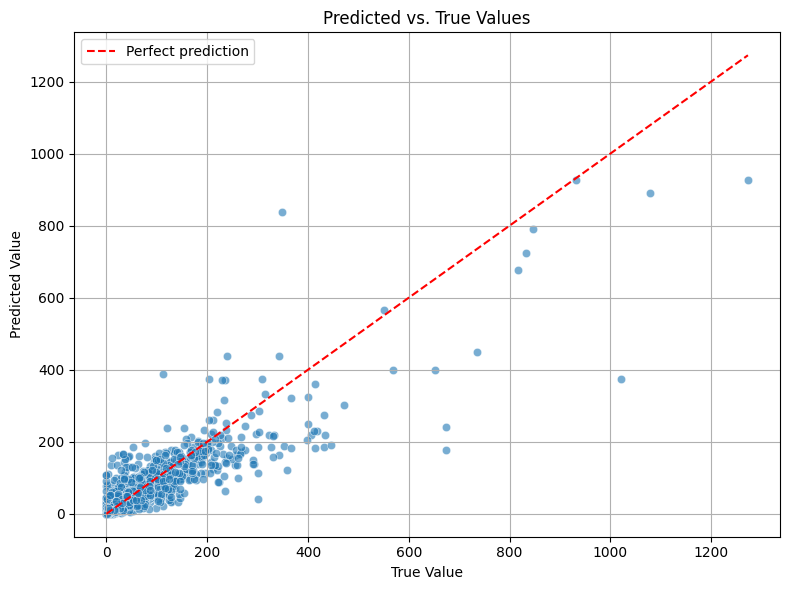

In [0]:
df_result = pd.DataFrame({"truth":truth, "prediction": prediction})
df_result.columns = ['y_true', 'y_pred']
plt.figure(figsize=(8, 6))
sns.scatterplot(x='y_true', y='y_pred', data=df_result, alpha=0.6)
plt.plot([df_result.y_true.min(), df_result.y_true.max()],
         [df_result.y_true.min(), df_result.y_true.max()],
         '--', color='red', label='Perfect prediction')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title('Predicted vs. True Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

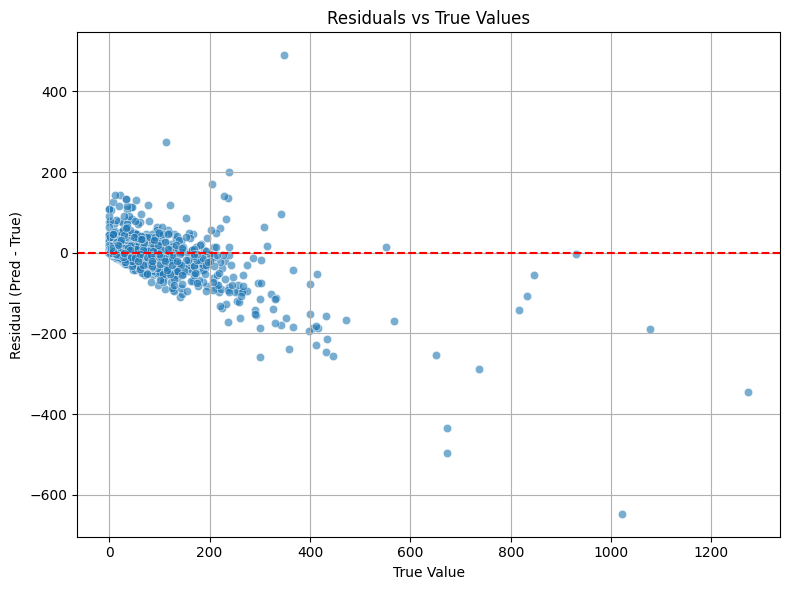

In [0]:
df_result["residual"] = df_result["y_pred"] - df_result["y_true"]

plt.figure(figsize=(8, 6))
sns.scatterplot(x="y_true", y="residual", data=df_result, alpha=0.6)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("True Value")
plt.ylabel("Residual (Pred - True)")
plt.title("Residuals vs True Values")
plt.grid(True)
plt.tight_layout()
plt.show()

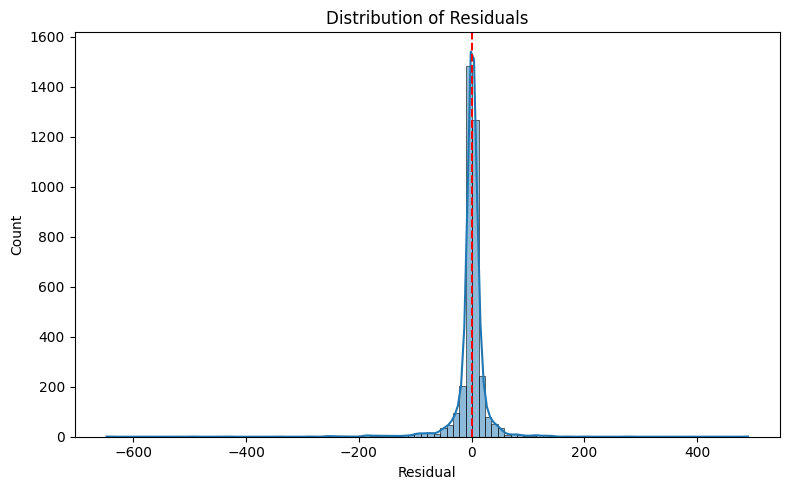

In [0]:
plt.figure(figsize=(8, 5))
sns.histplot(df_result["residual"], kde=True, bins=100)
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.tight_layout()
plt.show()

### Feature importance exploration

In [0]:
preproc = pipeline.named_steps["preprocessor"]
xgb_model = pipeline.named_steps["model"]
feature_names = preproc.get_feature_names_out()
importances = xgb_model.feature_importances_
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)
print(f"There are {len(importance_df)} features in total to train the model")
print('Here the top 10 most important features')
importance_df.head(10)

There are 255 features in total to train the model
Here the top 10 most important features


,feature,importance
7,numeric__purchases_lag1,0.218022
3,numeric__base_line_purchases,0.118250
1,numeric__discount_rank,0.091080
10,categorical__INDEX_GROUP_NAME_Divided,0.083823
6,numeric__markdown,0.051076
253,categorical__week_week1,0.047838
5,numeric__is_first_md_day,0.037456
11,categorical__INDEX_GROUP_NAME_Home,0.034072
202,categorical__PRODUCT_TYPE_NAME_Jumper/Sweater,0.026497
254,categorical__week_week2,0.024317


### Case level investigation

In [0]:
df_test = df_train.loc[y_test.index][['article', 'date', 'purchases'] + num_cols + cat_cols]
df_test['prediction'] = prediction
df_test['uplift'] = df_test['prediction']/df_test['base_line_purchases'].round(2)

In [0]:
df_test[df_test['article']==510563004][['week','date','markdown','price','discount_rank','purchases','uplift'] + cat_cols].sort_values(by='date')

,week,date,markdown,price,discount_rank,purchases,uplift,INDEX_GROUP_NAME,DEPARTMENT_NAME,PRODUCT_TYPE_NAME,week
2817,week0,2017-10-05,0,99.0,2,12.0,0.711102,Menswear,Jacket,Coat,week0
2818,week0,2017-10-06,0,99.0,2,11.0,0.851872,Menswear,Jacket,Coat,week0
2819,week0,2017-10-07,0,99.0,1,15.0,0.851872,Menswear,Jacket,Coat,week0
8184,week1,2017-10-10,1,99.0,2,67.0,2.825192,Menswear,Jacket,Coat,week1
8186,week1,2017-10-12,1,99.0,2,48.0,1.423019,Menswear,Jacket,Coat,week1
8187,week1,2017-10-13,1,99.0,2,60.0,3.001737,Menswear,Jacket,Coat,week1
8188,week1,2017-10-14,1,99.0,2,41.0,3.018582,Menswear,Jacket,Coat,week1
8189,week1,2017-10-15,1,99.0,2,67.0,2.698067,Menswear,Jacket,Coat,week1
13062,week2,2017-10-16,1,99.0,1,0.0,2.161344,Menswear,Jacket,Coat,week2
13063,week2,2017-10-17,1,99.0,1,0.0,0.180945,Menswear,Jacket,Coat,week2
